In [4]:
import pandas as pd
import geopandas as gpd
from shapely import Point
import numpy as np
import os
print(os.getcwd())

/home/jovyan/data-analyses/transit_priority_infrastructure


In [5]:
sfmta_signals = pd.read_csv('Traffic_Signals_20240205.csv')
sfmta_signals.head()


,objectid,CNN,STREET1,STREET2,DETECTION,STREET3,SUP_DIST,STREET4,SIG_NUM,TYPE,...,shape,data_as_of,data_loaded_at,analysis_neighborhood,supervisor_district,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,12937,22245000,GENNESSEE,MONTEREY,NaN,NaN,7.0,NaN,9393500,SIGNAL,...,POINT (-122.451146667 37.731536847),04/26/2023 03:24:48 PM,04/26/2023 03:24:48 PM,West of Twin Peaks,7.0,95.0,95.0,9.0,8.0,41.0
1,13744,26700000,CHESTNUT,FRANKLIN,NaN,NaN,2.0,NaN,9273500,SIGNAL,...,POINT (-122.426377344 37.802071872),04/26/2023 03:24:48 PM,04/26/2023 03:24:48 PM,Marina,2.0,17.0,17.0,4.0,6.0,13.0
2,13578,26005000,CASTRO,DUBOCE,NaN,NaN,8.0,NaN,9262500,SIGNAL,...,POINT (-122.435794213 37.769058453),04/26/2023 03:24:48 PM,04/26/2023 03:24:48 PM,Haight Ashbury,8.0,112.0,112.0,7.0,5.0,3.0
3,13526,26433000,STANYAN,WALLER,NaN,NaN,5.8,NaN,9534000,SIGNAL,...,POINT (-122.453352288 37.768246025),04/26/2023 03:24:48 PM,04/26/2023 03:24:48 PM,Golden Gate Park,5.0,25.0,25.0,7.0,11.0,12.0
4,13295,24867000,GREENWICH,SANSOME,NaN,NaN,3.0,NaN,9419500,SIGNAL,...,POINT (-122.403159607 37.80309838),04/26/2023 03:24:48 PM,04/26/2023 03:24:48 PM,Financial District/South Beach,3.0,77.0,77.0,6.0,3.0,8.0


In [6]:
def parse_point_geometry(geometry_str):
    coordinates = geometry_str.replace("POINT", "").strip().lstrip("(").rstrip(")").split()
    x, y = map(float, coordinates)
    point = Point(x, y)
    return point

sfmta_signals['geometry'] = sfmta_signals['shape'].apply(parse_point_geometry)

In [7]:
gdf = gpd.GeoDataFrame(sfmta_signals, geometry='geometry')

<AxesSubplot:>

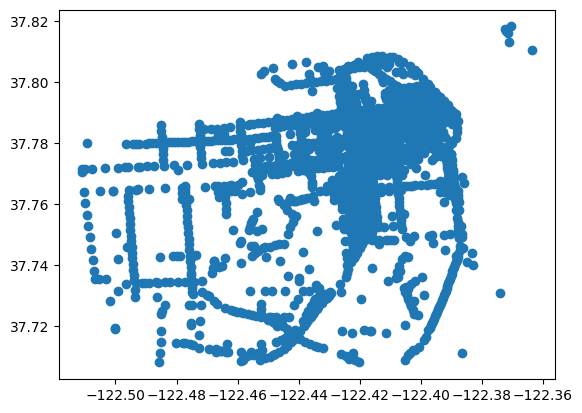

In [8]:
gdf.plot()

In [9]:
def merge_columns(row):
    if row['CALTRANS'] == 'X':
        return 'Caltrans'
    else:
        return 'SFMTA'

gdf['owner'] = gdf.apply(merge_columns, axis=1)

## Get only TSP signals

In [10]:
remove_list = ['FIRE PREEMPT', 'TSP-Planned,FIRE PREEMPT', 'TSP-Planned', 'nan']
gdf['PREEMPT_PR'] = gdf['PREEMPT_PR'].replace('nan', np.nan)
# Filter the GeoDataFrame to remove rows with values in the remove_list
filtered_gdf = gdf[~(gdf['PREEMPT_PR'].isin(remove_list) | gdf['PREEMPT_PR'].isna())]

filtered_gdf["PREEMPT_PR"].unique()

array(['TSP,FIRE PREEMPT', 'CABLE CAR PREEMPTION', 'TSP',
       'TSP,HEAVY RAIL PREEMPT', 'CABLE CAR PREEMPTION,FIRE PREEMPT',
       'TRANSIT PREEMPT', 'ACTUATED TRANSIT PHASE',
       'FIRE PREEMPT,TRANSIT PREEMPT', 'TSP,FIRE PREEMPT,TRANSIT PREEMPT',
       'TSP,CABLE CAR PREEMPT',
       'TSP,ACTUATED TRANSIT PHASE,TRANSIT PREEMPT', 'BRIDGE PREEMPT',
       'HEAVY RAIL,FIRE,BRIDGE, TRANSIT PREEMPT', 'TSP,TRANSIT PREEMPT',
       'TSP,ACTUATED TRANSIT PHASE',
       'TSP,ACTUATED TRANSIT PHASE,FIRE PREEMPT', 'TSP,BRIDGE PREEMPT',
       'HEAVY RAIL,BRIDGE PREEMPT', 'HEAVY RAIL PREEMPT',
       'HEAVY RAIL,BRIDGE PREEMPT, TRANSIT PREEMPT'], dtype=object)

In [11]:
filtered_gdf.columns
gdf_new = filtered_gdf[['STREET1','STREET2','STREET3','STREET4','PREEMPT_PR','LAST_UPGRA','data_as_of','geometry','owner']].copy()
gdf_new.rename(columns={'PREEMPT_PR':'TSP_Type','LAST_UPGRA':'start_date'},inplace=True)

<AxesSubplot:>

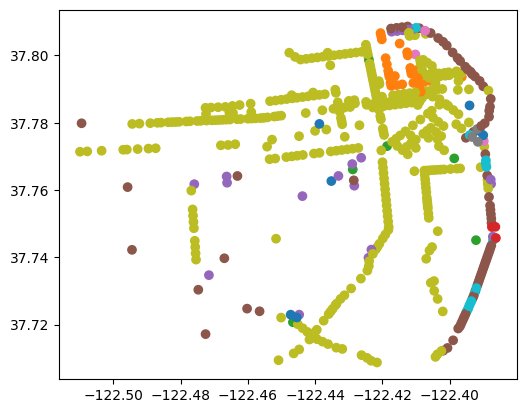

In [12]:
gdf_new.plot(gdf_new['TSP_Type'])
# Manually check to see if this matches 
# https://www.sfmta.com/sites/default/files/reports-and-documents/2023/02/bus_transit_signal_priority.pdf

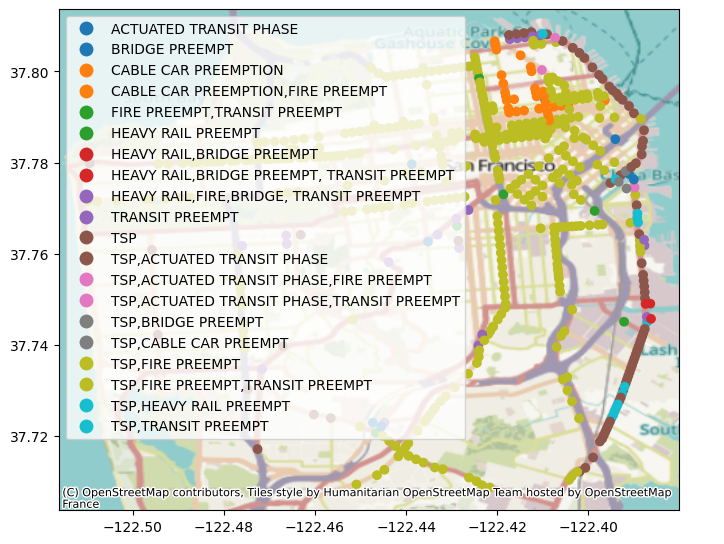

In [42]:
import contextily as ctx
from matplotlib import pyplot as plt

gdf_new.set_crs(epsg=4326)

ax = gdf_new.plot(column='TSP_Type', legend=True, figsize=(8, 10))

# Add basemap
ctx.add_basemap(ax, zoom=12, crs='EPSG:4326')


# Show plot
plt.show()
%matplotlib inline


In [41]:
print(gdf_new.iloc[2])

STREET1                                   03RD ST
STREET2                                  LE CONTE
STREET3                                       NaN
STREET4                                       NaN
TSP_Type                                      TSP
start_date                                   2005
data_as_of                 04/26/2023 03:25:40 PM
geometry      POINT (-122.397477616 37.718834533)
owner                                       SFMTA
Name: 12, dtype: object


In [10]:
for i in gdf_new["TSP_Type"].unique():
    print(str(i))

TSP,FIRE PREEMPT
CABLE CAR PREEMPTION
TSP
TSP,HEAVY RAIL PREEMPT
CABLE CAR PREEMPTION,FIRE PREEMPT
TRANSIT PREEMPT
ACTUATED TRANSIT PHASE
FIRE PREEMPT,TRANSIT PREEMPT
TSP,FIRE PREEMPT,TRANSIT PREEMPT
TSP,CABLE CAR PREEMPT
TSP,ACTUATED TRANSIT PHASE,TRANSIT PREEMPT
BRIDGE PREEMPT
HEAVY RAIL,FIRE,BRIDGE, TRANSIT PREEMPT
TSP,TRANSIT PREEMPT
TSP,ACTUATED TRANSIT PHASE
TSP,ACTUATED TRANSIT PHASE,FIRE PREEMPT
TSP,BRIDGE PREEMPT
HEAVY RAIL,BRIDGE PREEMPT
HEAVY RAIL PREEMPT
HEAVY RAIL,BRIDGE PREEMPT, TRANSIT PREEMPT


In [11]:
gdf_new.head()

,STREET1,STREET2,STREET3,STREET4,TSP_Type,start_date,data_as_of,geometry,owner
5,04TH ST,16TH ST,NaN,NaN,"TSP,FIRE PREEMPT",2010,04/26/2023 03:25:40 PM,POINT (-122.39080 37.76680),SFMTA
11,JACKSON,POWELL,NaN,NaN,CABLE CAR PREEMPTION,0,04/26/2023 03:24:48 PM,POINT (-122.40990 37.79562),SFMTA
12,03RD ST,LE CONTE,NaN,NaN,TSP,2005,04/26/2023 03:25:40 PM,POINT (-122.39748 37.71883),SFMTA
13,KING,MIDBLOCK AT,04TH ST,05TH ST,TSP,1997,04/26/2023 03:25:40 PM,POINT (-122.39519 37.77553),SFMTA
15,03RD ST,INGERSON,NaN,NaN,TSP,2004,04/26/2023 03:24:48 PM,POINT (-122.39627 37.72098),SFMTA


In [12]:
gdf_new.to_file("SFTMA_signals.json", driver="GeoJSON")